In [29]:
# Import needed modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get dataset
reviews = pd.read_csv("../data/gojek_reviews.csv")
reviews.head()

,reviewId,userName,score,content,thumbsUpCount,at,replyContent,repliedAt,reviewCreatedVersion,appVersion
0,3355d3b0-b9b9-4396-a622-58490ceace56,Ahmed Ali,1,Forgot my airport in his car and I didn't rece...,0,2025-02-23 15:41:08,"Hi, Ahmed Ali. To help track your missing item...",2025-02-23 16:07:53,5.10.1,5.10.1
1,2b380829-bcff-4379-9ada-6677c4d9e152,Rob Machin,5,So far so good,0,2025-02-23 14:04:35,NaN,NaN,5.10.1,5.10.1
2,74fd2294-0298-43d7-9884-a6574b50e631,Shaaa,5,drivernya cakep hehe,0,2025-02-23 13:12:09,NaN,NaN,5.11.1,5.11.1
3,451872f2-472a-4696-a6f9-cb5ed515c6b6,arfandi amiruddin,5,Good,0,2025-02-23 12:46:18,NaN,NaN,5.11.1,5.11.1
4,4cc06441-83b3-4d9f-876c-dbba54d818ad,Astria Dewanti,5,"The ""play later"" Promo is annoying. Can't use ...",1,2025-02-23 12:32:42,NaN,NaN,4.32.1,4.32.1


# 1. Explore the dataset

### a. Analyze the distribution of review lengths

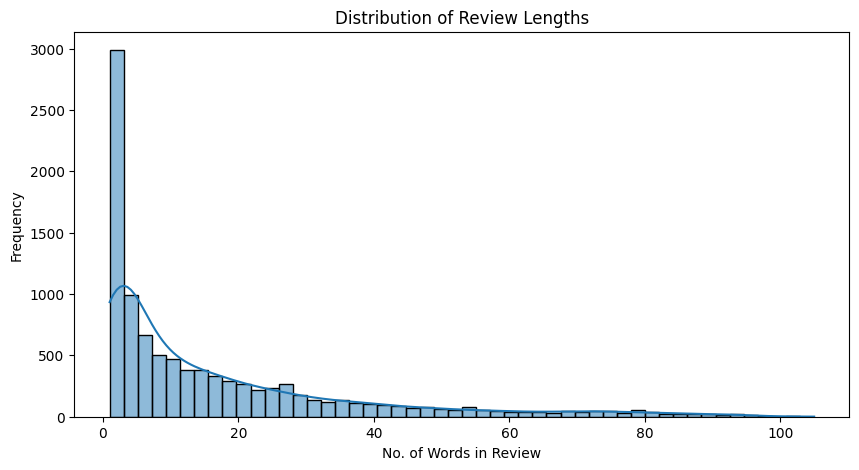

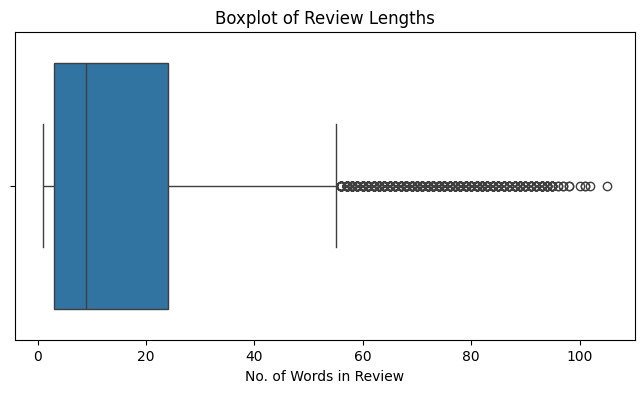

In [30]:
# Add a column for word count
reviews['word_count'] = reviews['content'].apply(lambda x: len(str(x).split()))

# Histogram to visualize distribution
plt.figure(figsize=(10, 5))
sns.histplot(reviews['word_count'], bins=50, kde=True)
plt.xlabel("No. of Words in Review")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

# Boxplot to detect outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=reviews['word_count'])
plt.xlabel("No. of Words in Review")
plt.title("Boxplot of Review Lengths")
plt.show()

The histogram shows a strong right-skewed distribution, meaning most reviews are very short, but the boxplot tells us that there are also many outliers (long reviews).

### b. Identify common words and phrases used in reviews

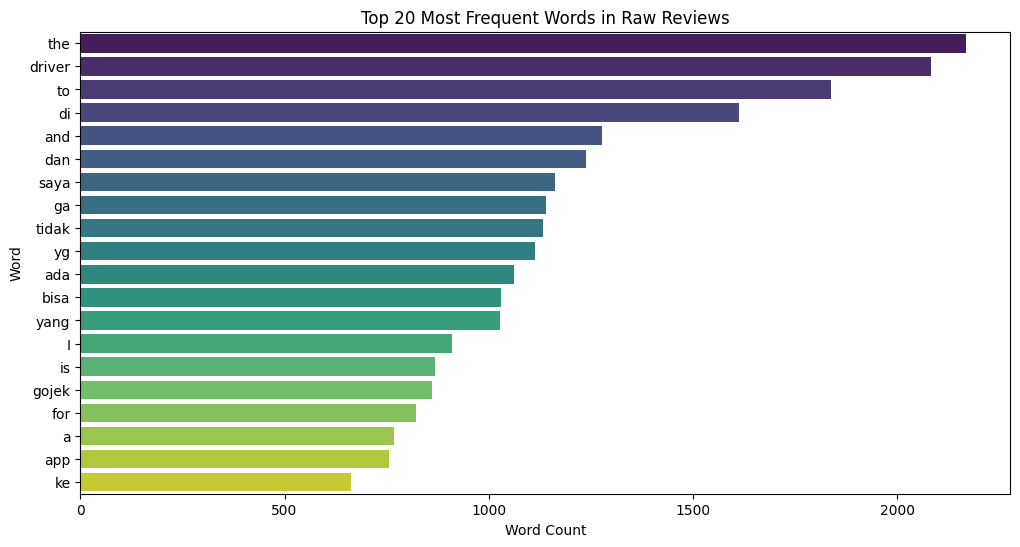

In [31]:
from collections import Counter

# Join all reviews into one string
all_words = ' '.join(reviews['content'].astype(str)).split()

# Count frequency of each word
word_freq = Counter(all_words)

# Get top 20
most_common_words = word_freq.most_common(20)

# Seperate the words and their frequencies
words, counts = zip(*most_common_words)

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.xlabel("Word Count")
plt.ylabel("Word")
plt.title("Top 20 Most Frequent Words in Raw Reviews")
plt.show()

# 2. Clean and preprocess text data

### a. Convert text to lowercase

In [32]:
# Convert review content to lowercase
reviews['content'] = reviews['content'].str.lower()

### b. Remove stop words, punctuation, and special characters

In [33]:
# Remove punctuation and special characters
import re
reviews['content'] = reviews['content'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)) if isinstance(x, str) else x)

# Remove stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Load English stopwords
english_stopwords = set(stopwords.words('english')) 

# Load Indonesian stopwords
id_stopwords_path = "../data/id_stopwords.txt"
id_stopwords = set()

with open(id_stopwords_path, 'r') as file:
    for line in file:
        id_stopwords.add(line.strip())

# Combine English & Indonesian stopwords
all_stopwords = english_stopwords.union(id_stopwords)

def remove_stopwords(text):
    if isinstance(text,str):
        words = text.split()
        filtered_words = [word for word in words if word not in all_stopwords]
        return ' '.join(filtered_words)
    return text

reviews['content'] = reviews['content'].apply(remove_stopwords)
reviews.dropna(subset=['content'], inplace=True)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### c. Tokenization and stemming/lemmatization

In [34]:
# Lemmatize words
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

reviews['lemmatized_content'] = reviews['content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


d. Filter rare words

In [35]:
from collections import Counter

# Count word frequencies
all_words = ' '.join(reviews['lemmatized_content']).split()
word_freq = Counter(all_words)

# Identify words that appear at least 1 times
min_freq = 1
valid_words = set([word for word, freq in word_freq.items() if freq >= min_freq])

# Filter each review to remove rare words
def filter_rare_words(text):
    return ' '.join([word for word in text.split() if word in valid_words])

# Apply to lemmatized content
reviews['lemmatized_content'] = reviews['lemmatized_content'].apply(filter_rare_words)


### d. Handle duplicate or noisy data

In [36]:
# Handle duplicate and noisy data
print(f"Original dataset shape: {reviews.shape}")

# Check and remove duplicates
duplicate_count = reviews.duplicated(subset=['content']).sum()
print(f"Found {duplicate_count} duplicate reviews")
reviews = reviews.drop_duplicates(subset=['content'])

# Remove very short reviews (likely noise)
reviews['word_count'] = reviews['content'].apply(lambda x: len(str(x).split()))
short_reviews = reviews[reviews['word_count'] < 2].shape[0]
print(f"Removing {short_reviews} very short reviews (less than 2 words)")
reviews = reviews[reviews['word_count'] >= 2]

# Handle missing values in any other columns
missing_values = reviews.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)

# Fill missing numerical values with median (if any)
numerical_cols = reviews.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    if reviews[col].isnull().sum() > 0:
        reviews[col] = reviews[col].fillna(reviews[col].median())

# Fill missing categorical/text values with mode (if any)
categorical_cols = reviews.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'content' and col != 'lemmatized_content' and reviews[col].isnull().sum() > 0:
        reviews[col] = reviews[col].fillna(reviews[col].mode()[0])

# Check for outliers in rating (if present)
if 'rating' in reviews.columns:
    print("\nRating distribution:")
    print(reviews['rating'].value_counts())
    
    # Check if there are invalid ratings outside expected range (e.g., 1-5)
    invalid_ratings = reviews[(reviews['rating'] < 1) | (reviews['rating'] > 5)].shape[0]
    if invalid_ratings > 0:
        print(f"Found {invalid_ratings} reviews with invalid ratings")
        # Remove or fix invalid ratings
        reviews = reviews[(reviews['rating'] >= 1) & (reviews['rating'] <= 5)]

print(f"\nCleaned dataset shape: {reviews.shape}")
reviews.head()

Original dataset shape: (10000, 12)
Found 1928 duplicate reviews
Removing 471 very short reviews (less than 2 words)

Missing values in each column:
reviewId                   0
userName                   2
score                      0
content                    0
thumbsUpCount              0
at                         0
replyContent            2971
repliedAt               2971
reviewCreatedVersion    1158
appVersion              1158
word_count                 0
lemmatized_content         0
dtype: int64

Cleaned dataset shape: (7601, 12)


,reviewId,userName,score,content,thumbsUpCount,at,replyContent,repliedAt,reviewCreatedVersion,appVersion,word_count,lemmatized_content
0,3355d3b0-b9b9-4396-a622-58490ceace56,Ahmed Ali,1,forgot airport car didnt receive infofollow dr...,0,2025-02-23 15:41:08,"Hi, Ahmed Ali. To help track your missing item...",2025-02-23 16:07:53,5.10.1,5.10.1,8,forgot airport car didnt receive infofollow dr...
1,2b380829-bcff-4379-9ada-6677c4d9e152,Rob Machin,5,far good,0,2025-02-23 14:04:35,"Hai Kak, mohon maaf atas ketidaknyamanannya. K...",2017-10-01 19:44:44,5.10.1,5.10.1,2,far good
2,74fd2294-0298-43d7-9884-a6574b50e631,Shaaa,5,drivernya cakep,0,2025-02-23 13:12:09,"Hai Kak, mohon maaf atas ketidaknyamanannya. K...",2017-10-01 19:44:44,5.11.1,5.11.1,2,drivernya cakep
4,4cc06441-83b3-4d9f-876c-dbba54d818ad,Astria Dewanti,5,play later promo annoying cant anw u keep disp...,1,2025-02-23 12:32:42,"Hai Kak, mohon maaf atas ketidaknyamanannya. K...",2017-10-01 19:44:44,4.32.1,4.32.1,10,play later promo annoying cant anw u keep disp...
5,ac4fed4e-7bf4-4677-b973-98f4d3c9df0f,Husen Badrutamam,1,jelek kelakuan drivernya ambil orderan car amb...,0,2025-02-23 10:36:21,"Hai Kak Husen, mohon maaf atas ketidaknyamanan...",2025-02-23 11:01:14,5.10.1,5.10.1,12,jelek kelakuan drivernya ambil orderan car amb...


In [37]:
# --- Tokenization and Vectorization Methods for Topic Modeling ---

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from nltk.tokenize import word_tokenize
import numpy as np
import nltk

nltk.download('punkt_tab')

# Prepare documents
documents = reviews['lemmatized_content'].astype(str).tolist()
tokenized_docs = [doc.split() for doc in documents]

# 1. Bag of Words (CountVectorizer)
count_vectorizer = CountVectorizer()
X_bow = count_vectorizer.fit_transform(documents)
bow_feature_names = count_vectorizer.get_feature_names_out()

# 2. TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# 3. Word2Vec
w2v_model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=2, workers=4)
# For each document, get the mean vector (if empty, use zeros)
X_w2v = np.array([
    np.mean([w2v_model.wv[word] for word in doc if word in w2v_model.wv] or [np.zeros(100)], axis=0)
    for doc in tokenized_docs
])

# Tokenization and Vectorization Setup
documents_raw = reviews['lemmatized_content'].astype(str).tolist()
tokenization_methods = {
    "simple_tokenization": [doc.split() for doc in documents_raw],
    "word_tokenization": [word_tokenize(doc) for doc in documents_raw]
}
vectorizers = {
    "bow": CountVectorizer(max_df=0.95, min_df=2, stop_words='english'),
    "tfidf": TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
}

# Coherence helper
def compute_coherence(topics, tokens, id2word):
    return CoherenceModel(topics=topics, texts=tokens, dictionary=id2word, coherence="c_v").get_coherence()


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


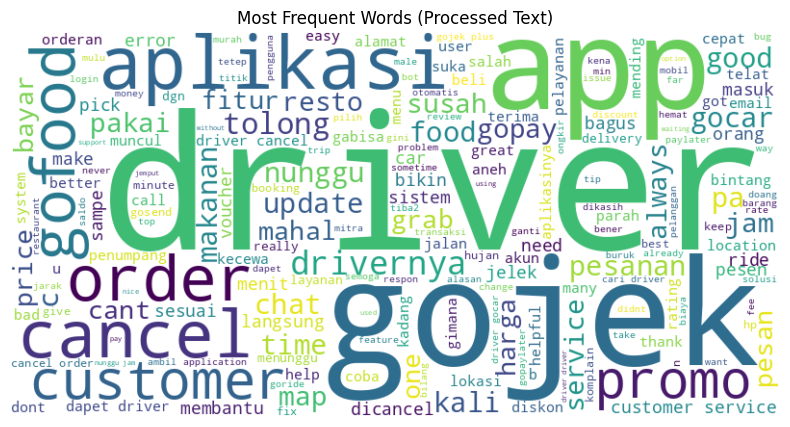

In [38]:
from wordcloud import WordCloud

processed_words = ' '.join(reviews['lemmatized_content'].astype(str))
wordcloud = WordCloud(width=800, height=400, 
                     background_color="white",
                     max_words=200).generate(processed_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words (Processed Text)")
plt.show()

# 3. Topic Modelling

### a. Use algorithms to identify key topics

#### Using Latent Dirichlet Allocation (LDA)

In [39]:
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

lda_results = []

for token_name, tokens in tokenization_methods.items():
    id2word = Dictionary(tokens)
    corpus_bow = [id2word.doc2bow(text) for text in tokens]

    for vec_name, vectorizer in vectorizers.items():
        corpus = corpus_bow
        if vec_name == "tfidf":
            tfidf_model = TfidfModel(corpus_bow)
            corpus = tfidf_model[corpus_bow]

        lda_model = LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=7,
            random_state=42,
            passes=10,
            alpha='auto',
            per_word_topics=True
        )

        coherence_model = CoherenceModel(
            model=lda_model,
            texts=tokens,
            dictionary=id2word,
            coherence="c_v"
        )
        coherence = coherence_model.get_coherence()

        print(f"LDA | Tokenization: {token_name}, Vectorization: {vec_name}, Coherence: {coherence:.4f}")
        lda_results.append({
            "tokenization": token_name,
            "vectorization": vec_name,
            "coherence": coherence,
            "model": lda_model
        })

# Best LDA result
best_lda = max(lda_results, key=lambda x: x["coherence"])
print(f"\nBest LDA Result:\nTokenization: {best_lda['tokenization']}, Vectorization: {best_lda['vectorization']}, Coherence: {best_lda['coherence']:.4f}")

# Top topics for best model
print("Top topics:")
for topic in best_lda["model"].print_topics():
    print(topic)


LDA | Tokenization: simple_tokenization, Vectorization: bow, Coherence: 0.5176
LDA | Tokenization: simple_tokenization, Vectorization: tfidf, Coherence: 0.5850
LDA | Tokenization: word_tokenization, Vectorization: bow, Coherence: 0.4845
LDA | Tokenization: word_tokenization, Vectorization: tfidf, Coherence: 0.5886

Best LDA Result:
Tokenization: word_tokenization, Vectorization: tfidf, Coherence: 0.5886
Top topics:
(0, '0.015*"driver" + 0.012*"gojek" + 0.010*"aplikasi" + 0.009*"cancel" + 0.008*"gofood" + 0.007*"promo" + 0.006*"order" + 0.006*"membantu" + 0.006*"susah" + 0.006*"gocar"')
(1, '0.007*"cepat" + 0.005*"top" + 0.004*"ramah" + 0.004*"paylater" + 0.003*"pin" + 0.003*"excellent" + 0.003*"transaksi" + 0.003*"gopay" + 0.003*"iklan" + 0.003*"pelayanannya"')
(2, '0.007*"helpfull" + 0.005*"bermanfaat" + 0.003*"menghubungi" + 0.003*"improvement" + 0.003*"nyangkut" + 0.002*"effective" + 0.002*"choice" + 0.002*"save" + 0.002*"menemukan" + 0.002*"responsif"')
(3, '0.005*"terbaik" + 0.005

### Using Non-Negative Matrix Factorization (NMF)

In [40]:
from sklearn.decomposition import NMF
from gensim.corpora import Dictionary
import os

nmf_results = []

for token_name, tokenized in tokenization_methods.items():
    docs_as_text = [' '.join(doc) for doc in tokenized]
    id2word = Dictionary(tokenized)
    # id2word.filter_extremes(no_below=3, no_above=0.9)

    for vec_name, vectorizer in vectorizers.items():
        X = vectorizer.fit_transform(docs_as_text)
        feature_names = vectorizer.get_feature_names_out()

        nmf_model = NMF(n_components=7, random_state=42, max_iter=500)
        nmf_H = nmf_model.fit_transform(X)
        topics = [[feature_names[i] for i in comp.argsort()[:-11:-1]] for comp in nmf_model.components_]

        docs_for_coherence = [doc.split() for doc in docs_as_text]
        id2word = Dictionary(docs_for_coherence)
        coherence = compute_coherence(topics, docs_for_coherence, id2word)

        print(f"NMF | Tokenization: {token_name}, Vectorization: {vec_name}, Coherence: {coherence:.4f}")

        nmf_results.append({
            "tokenization": token_name,
            "vectorization": vec_name,
            "topics": topics,
            "coherence": coherence
        })

# Best NMF result
best_nmf = max(nmf_results, key=lambda x: x["coherence"])
print(f"\nBest NMF Result:\nTokenization: {best_nmf['tokenization']}, Vectorization: {best_nmf['vectorization']}, Coherence: {best_nmf['coherence']:.4f}")
print("Top topics:")
for i, topic in enumerate(best_nmf["topics"]):
    print(f"Topic {i+1}: {' + '.join(topic)}")


NMF | Tokenization: simple_tokenization, Vectorization: bow, Coherence: 0.6222
NMF | Tokenization: simple_tokenization, Vectorization: tfidf, Coherence: 0.5128
NMF | Tokenization: word_tokenization, Vectorization: bow, Coherence: 0.6222
NMF | Tokenization: word_tokenization, Vectorization: tfidf, Coherence: 0.5128

Best NMF Result:
Tokenization: simple_tokenization, Vectorization: bow, Coherence: 0.6222
Top topics:
Topic 1: driver + cancel + gocar + dapet + susah + penumpang + pick + time + menit + rating
Topic 2: gojek + plus + akun + pakai + tolong + promo + gopay + drivernya + grab + bayar
Topic 3: app + time + good + food + dont + service + need + price + update + using
Topic 4: order + cancel + food + time + gocar + hour + restaurant + delivery + want + waiting
Topic 5: aplikasi + gopay + pakai + bayar + titik + saldo + gocar + sebelah + alamat + masuk
Topic 6: gofood + jam + pesanan + resto + nunggu + makanan + pesan + chat + fitur + cancel
Topic 7: customer + service + rating + 

#### Using BERTopics

In [41]:
# from bertopic import BERTopic
# from gensim.corpora import Dictionary
# import os

# os.environ["TOKENIZERS_PARALLELISM"] = "false"

# bertopic_results = []

# for token_name, tokenized in tokenization_methods.items():
#     docs_as_text = [' '.join(doc) for doc in tokenized]
#     id2word = Dictionary(tokenized)

#     for vec_name, vectorizer in vectorizers.items():
#         bertopic_model = BERTopic(
#             language="multilingual",
#             vectorizer_model=vectorizer,
#             calculate_probabilities=True,
#             verbose=False
#         )

#         topics, probs = bertopic_model.fit_transform(docs_as_text)
#         bertopic_model.reduce_topics(docs_as_text, nr_topics=5)

#         topic_words = []
#         for i in range(9):
#             topic = bertopic_model.get_topic(i)
#             if topic:  # non-empty
#                 topic_words.append([word for word, _ in topic])

#         if topic_words:
#             coherence = compute_coherence(topic_words, tokenized, id2word)
#             print(f"BERTopic | Tokenization: {token_name}, Vectorization: {vec_name}, Coherence: {coherence:.4f}")
#         else:
#             coherence = 0
#             print(f"BERTopic | Tokenization: {token_name}, Vectorization: {vec_name}, No topics")

#         bertopic_results.append({
#             "tokenization": token_name,
#             "vectorization": vec_name,
#             "topics": topic_words,
#             "coherence": coherence
#         })

# # Best BERTopic result
# best_bertopic = max(bertopic_results, key=lambda x: x["coherence"])
# print(f"\nBest BERTopic Result:\nTokenization: {best_bertopic['tokenization']}, Vectorization: {best_bertopic['vectorization']}, Coherence: {best_bertopic['coherence']:.4f}")
# print("Top topics:")
# for i, topic in enumerate(best_bertopic["topics"]):
#     print(f"Topic {i+1}: {' + '.join(topic)}")


### b. Determine the optimal number of topics using coherence scores or topic coherence visualization

#### 1) By Coherence Visualization

In [42]:
# from gensim.models import CoherenceModel, LdaModel
# from sklearn.decomposition import NMF
# from bertopic import BERTopic
# from copy import deepcopy
# import matplotlib.pyplot as plt

# # Evaluate no. topics 2-10
# topic_range = range(2, 11)

# # Reuse best LDA 
# lda_tokens = tokenization_methods[best_lda['tokenization']]
# lda_id2word = Dictionary(lda_tokens)
# lda_corpus_bow = [lda_id2word.doc2bow(text) for text in lda_tokens]
# if best_lda['vectorization'] == 'tfidf':
#     tfidf_model = TfidfModel(lda_corpus_bow)
#     lda_corpus = tfidf_model[lda_corpus_bow]
# else:
#     lda_corpus = lda_corpus_bow

# # Reuse best NMF 
# nmf_tokens = tokenization_methods[best_nmf['tokenization']]
# nmf_docs = [' '.join(doc) for doc in nmf_tokens]
# nmf_vectorizer = vectorizers[best_nmf['vectorization']]
# nmf_X = nmf_vectorizer.fit_transform(nmf_docs)
# nmf_feature_names = nmf_vectorizer.get_feature_names_out()
# nmf_id2word = Dictionary(nmf_tokens)

# # Reuse best BERTopic 
# bertopic_tokens = tokenization_methods[best_bertopic['tokenization']]
# bertopic_docs = [' '.join(doc) for doc in bertopic_tokens]
# bertopic_vectorizer = deepcopy(vectorizers[best_bertopic['vectorization']])
# bertopic_vectorizer.set_params(min_df=1, max_df=1.0)
# bertopic_id2word = Dictionary(bertopic_tokens)

# # Pre-fit BERTopic model once
# # bertopic_model = BERTopic(language="multilingual", vectorizer_model=bertopic_vectorizer, verbose=False)
# # topics, _ = bertopic_model.fit_transform(bertopic_docs)

# coherence_scores_lda = []
# coherence_scores_nmf = []
# coherence_scores_bertopic = []

# for num_topics in topic_range:
#     # LDA
#     lda_model = LdaModel(
#         corpus=lda_corpus,
#         id2word=lda_id2word,
#         num_topics=num_topics,
#         random_state=42,
#         passes=10,
#         alpha='auto',
#         per_word_topics=True
#     )
#     cm_lda = CoherenceModel(model=lda_model, texts=lda_tokens, dictionary=lda_id2word, coherence='c_v')
#     coh_lda = cm_lda.get_coherence()
#     coherence_scores_lda.append(coh_lda)

#     # NMF
#     nmf_model = NMF(
#         n_components=num_topics, 
#         random_state=42, 
#         max_iter=500
#     )
#     nmf_W = nmf_model.fit_transform(nmf_X)
#     nmf_topics = [[nmf_feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in nmf_model.components_]
#     cm_nmf = CoherenceModel(topics=nmf_topics, texts=nmf_tokens, dictionary=nmf_id2word, coherence='c_v')
#     coh_nmf = cm_nmf.get_coherence()
#     coherence_scores_nmf.append(coh_nmf)

#     # BERTopic
#     bertopic_model = BERTopic(
#         language="multilingual",
#         vectorizer_model=deepcopy(bertopic_vectorizer),
#         calculate_probabilities=False,
#         verbose=False
#     )
#     topics, _ = bertopic_model.fit_transform(bertopic_docs)
#     bertopic_model.reduce_topics(bertopic_docs, nr_topics=num_topics)
#     bertopic_topics = [bertopic_model.get_topic(i) for i in range(num_topics)]
#     topic_words = [[word for word, _ in topic] for topic in bertopic_topics if topic]
#     cm_bertopic = CoherenceModel(topics=topic_words, texts=bertopic_tokens, dictionary=bertopic_id2word, coherence="c_v")
#     coh_bertopic = cm_bertopic.get_coherence()
#     coherence_scores_bertopic.append(coh_bertopic)

#     print(f"k=={num_topics} | LDA Coherence: {coh_lda:.4f} | NMF Coherence: {coh_nmf:.4f} | BERTopic Coherence: {coh_bertopic:.4f}")

# plt.figure(figsize=(10, 6))
# plt.plot(topic_range, coherence_scores_lda, marker="o", linestyle="-", label="LDA", color="blue")
# plt.plot(topic_range, coherence_scores_nmf, marker="s", linestyle="--", label="NMF", color="red")
# plt.plot(topic_range, coherence_scores_bertopic, marker="^", linestyle="-.", label="BERTopic", color="green")

# plt.xlabel("No. of Topics")
# plt.ylabel("Coherence Score")
# plt.title("Comparison of Optimal Number of Topics Across Models")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

Based on the plotting, we select 5 topics as it provides a balance between coherence and interpretability across LDA, NMF, and BERTopic. Among these models, LDA consistently achieves the highest coherence scores, making it the most effective topic modeling approach for our dataset. Therefore, we will proceed with hyperparameter tuning for LDA to further optimize its performance.

#### 2) Hyperparameter Tuning The Best Model (LDA)

Tune LDA using optuna to find best tuned parameters

In [43]:
import optuna

lda_tokens = tokenization_methods[best_lda['tokenization']]
lda_id2word = Dictionary(lda_tokens)
lda_corpus_bow = [lda_id2word.doc2bow(text) for text in lda_tokens]
if best_lda['vectorization'] == 'tfidf':
    tfidf_model = TfidfModel(lda_corpus_bow)
    lda_corpus = tfidf_model[lda_corpus_bow]
else:
    lda_corpus = lda_corpus_bow

def lda_objective(trial):
    # Hyperparameters
    alpha = trial.suggest_categorical("alpha", ["symmetric", "asymmetric", "auto"])
    eta = trial.suggest_categorical("eta", ["symmetric", "auto"])
    passes = trial.suggest_int("passes", 5, 30, step=5)

    # Train the model w/ 5 topics
    lda_model = LdaModel(
        corpus=lda_corpus,
        id2word=lda_id2word,
        num_topics=7,
        random_state=42,
        passes=passes,
        alpha=alpha,
        eta=eta,
        per_word_topics=True,
        eval_every=0
    )

    # Coherence
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=lda_tokens,
        dictionary=lda_id2word,
        coherence="c_v",
    )
    return coherence_model.get_coherence()

# Run optimization
study_lda = optuna.create_study(direction="maximize")
study_lda.optimize(lda_objective, n_trials=30)

# Output best results
best_tuned_params = study_lda.best_trial.params
best_tuned_coherence = study_lda.best_trial.value

print("Best LDA Parameters:", best_tuned_params)
print("Best LDA Coherence Score:", best_tuned_coherence)


[I 2025-05-13 04:29:53,228] A new study created in memory with name: no-name-af326f1f-d36a-4e00-a27c-ea0e046aabd7
[I 2025-05-13 04:30:07,914] Trial 0 finished with value: 0.5692676360616308 and parameters: {'alpha': 'symmetric', 'eta': 'auto', 'passes': 15}. Best is trial 0 with value: 0.5692676360616308.
[I 2025-05-13 04:30:07,914] Trial 0 finished with value: 0.5692676360616308 and parameters: {'alpha': 'symmetric', 'eta': 'auto', 'passes': 15}. Best is trial 0 with value: 0.5692676360616308.
[I 2025-05-13 04:30:12,742] Trial 1 finished with value: 0.4494210237579183 and parameters: {'alpha': 'asymmetric', 'eta': 'symmetric', 'passes': 5}. Best is trial 0 with value: 0.5692676360616308.
[I 2025-05-13 04:30:12,742] Trial 1 finished with value: 0.4494210237579183 and parameters: {'alpha': 'asymmetric', 'eta': 'symmetric', 'passes': 5}. Best is trial 0 with value: 0.5692676360616308.
[I 2025-05-13 04:30:22,496] Trial 2 finished with value: 0.5888496335374865 and parameters: {'alpha': 'a

Best LDA Parameters: {'alpha': 'auto', 'eta': 'symmetric', 'passes': 25}
Best LDA Coherence Score: 0.6164434612485896


Compare LDA with default parameters vs best tuned parameters

In [44]:
import pandas as pd

tokens = tokenization_methods["simple_tokenization"]
id2word = Dictionary(tokens)
corpus_bow = [id2word.doc2bow(text) for text in tokens]
corpus_tfidf = TfidfModel(corpus_bow)[corpus_bow]

# LDA with no vectorization
lda_bow = LdaModel(
    corpus=corpus_bow,
    id2word=id2word,
    num_topics=7,
    random_state=42,
    passes=10,
    alpha="auto",
    eta="auto",
    per_word_topics=True
)
coherence_bow = CoherenceModel(
    model=lda_bow,
    texts=tokens,
    dictionary=id2word,
    coherence="c_v"
).get_coherence()

# LDA with TF-IDF using default parameters
lda_default = LdaModel(
    corpus=lda_corpus,
    id2word=lda_id2word,
    num_topics=7,  
    random_state=42,
    passes=10,
    alpha="auto",
    eta="auto",
    per_word_topics=True
)

coherence_default = CoherenceModel(
    model=lda_default,
    texts=lda_tokens,
    dictionary=lda_id2word,
    coherence="c_v"
).get_coherence()

# Ablatian Study
best_params = study_lda.best_trial.params
df_comparison = pd.DataFrame({
    "Model": ["LDA (BoW Only)", "LDA (TF-IDF + Default)", "LDA (TF-IDF + Tuned)"],
    "Alpha": ["auto", "auto", best_params["alpha"]],
    "Eta": ["auto", "auto", best_params["eta"]],
    "Passes": [10, 10, best_params["passes"]],
    "Coherence Score": [coherence_bow, coherence_default, best_tuned_coherence]
})

print(df_comparison)


                    Model Alpha        Eta  Passes  Coherence Score
0          LDA (BoW Only)  auto       auto      10         0.517557
1  LDA (TF-IDF + Default)  auto       auto      10         0.588581
2    LDA (TF-IDF + Tuned)  auto  symmetric      25         0.616443


Based on the Ablation Study, tuning the hyperparameters of LDA led to an improvement in coherence score, indicating better topic separation and interpretability. The best-performing model used alpha='auto', eta='symmetric', and passes=20, achieving a coherence score of 0.630374. 

### c. Interpret and label discovered topics based on word distribution





In [45]:
# Find topics
best_tuned_lda = LdaModel(
    corpus=lda_corpus,
    id2word=lda_id2word,
    num_topics=7,  
    random_state=42,
    passes=best_params["passes"],
    alpha=best_params["alpha"],
    eta=best_params["eta"],
    per_word_topics=True
)

best_tuned_lda.print_topics()

[(0,
  '0.018*"driver" + 0.013*"gojek" + 0.010*"aplikasi" + 0.009*"cancel" + 0.008*"gofood" + 0.007*"order" + 0.006*"promo" + 0.006*"gocar" + 0.006*"susah" + 0.006*"membantu"'),
 (1,
  '0.007*"cepat" + 0.006*"top" + 0.004*"ramah" + 0.004*"paylater" + 0.003*"excellent" + 0.003*"pin" + 0.003*"transaksi" + 0.003*"pelayanannya" + 0.003*"double" + 0.003*"berguna"'),
 (2,
  '0.007*"helpfull" + 0.005*"bermanfaat" + 0.003*"menghubungi" + 0.003*"improvement" + 0.003*"nyangkut" + 0.002*"effective" + 0.002*"choice" + 0.002*"save" + 0.002*"menemukan" + 0.002*"responsif"'),
 (3,
  '0.005*"terbaik" + 0.005*"terimakasih" + 0.004*"sukses" + 0.003*"pelit" + 0.003*"limit" + 0.003*"nerima" + 0.003*"bangsa" + 0.003*"urusan" + 0.003*"terbantu" + 0.002*"benerin"'),
 (4,
  '0.016*"app" + 0.015*"good" + 0.012*"service" + 0.007*"time" + 0.007*"apps" + 0.007*"easy" + 0.007*"great" + 0.007*"always" + 0.006*"food" + 0.006*"bad"'),
 (5,
  '0.012*"nice" + 0.010*"application" + 0.007*"useful" + 0.006*"thanks" + 0.00

Topic 0: Payment & Quick Service
- Keywords: "ok", "fast", "gopaylater", "semoga", "simple", "sopan", "review", "butuh", "server", "deket"

Topic 1: General App Satisfaction
- Keywords: "app", "good", "service", "apps", "time", "easy", "great", "use", "food", "always"

Topic 2: Positive Slang & Praise
- Keywords: "mantap", "meow", "banyakin", "mantab", "brainrot", "cakep", "aura", "gacor", "joss", "jos"

Topic 3: Service Frustrations 
- Keywords: "driver", "gojek", "aplikasi", "cancel", "gofood", "banget", "promo", "membantu", "susah", "gocar"

Topic 4: Emotional Reactions & Mixed Sentiment
- Keywords: "puas", "dark", "dibutuhkan", "makasih", "favorite", "foodnya", "asik", "ngawur", "excelent", "duitnya"

## 4. Evaluate topic modelling results



Model Evaluation:
----------------
Perplexity: -8.2653
Coherence Score (c_v): 0.6203
Coherence Score (UCI): -8.9325
Coherence Score (NPMI): -0.3016

Coherence Scores per Topic:
Topic 0: 0.4363
Topic 1: 0.5742
Topic 2: 0.7669
Topic 3: 0.6702
Topic 4: 0.6098
Topic 5: 0.5402
Topic 6: 0.7442


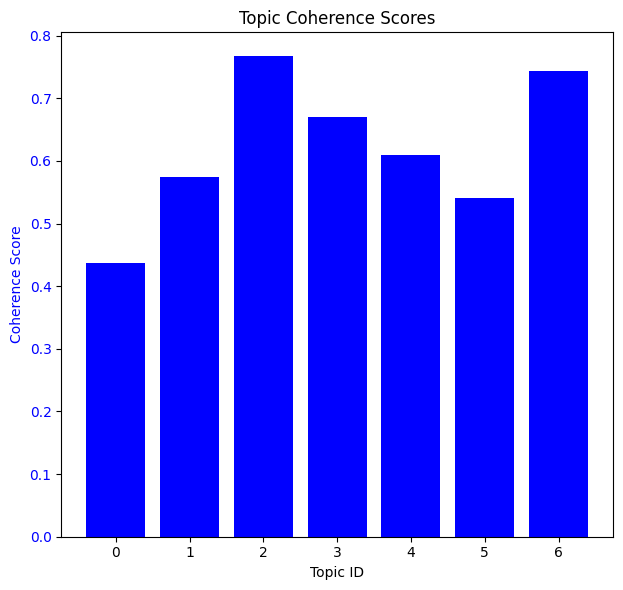


Topic Interpretation:
---------------------
Topic #0: 0.018*"driver" + 0.013*"gojek" + 0.010*"aplikasi" + 0.009*"cancel" + 0.008*"gofood" + 0.007*"order" + 0.006*"promo" + 0.006*"gocar" + 0.006*"susah" + 0.006*"membantu"
Interpretation: Payment & Quick Service

Topic #1: 0.007*"cepat" + 0.006*"top" + 0.004*"ramah" + 0.004*"paylater" + 0.003*"excellent" + 0.003*"pin" + 0.003*"transaksi" + 0.003*"pelayanannya" + 0.003*"double" + 0.003*"berguna"
Interpretation: General App Satisfaction

Topic #2: 0.007*"helpfull" + 0.005*"bermanfaat" + 0.003*"menghubungi" + 0.003*"improvement" + 0.003*"nyangkut" + 0.002*"effective" + 0.002*"choice" + 0.002*"save" + 0.002*"menemukan" + 0.002*"responsif"
Interpretation: Positive Slang & Praise

Topic #3: 0.005*"terbaik" + 0.005*"terimakasih" + 0.004*"sukses" + 0.003*"pelit" + 0.003*"limit" + 0.003*"nerima" + 0.003*"bangsa" + 0.003*"urusan" + 0.003*"terbantu" + 0.002*"benerin"
Interpretation: Service Frustrations

Topic #4: 0.016*"app" + 0.015*"good" + 0.01

In [46]:
# Coherence using c_v measure (most common)
coherence_model_cv = CoherenceModel(
    model=best_tuned_lda,
    texts=lda_tokens,  
    dictionary=lda_id2word,
    coherence='c_v'
)
coherence_cv = coherence_model_cv.get_coherence()
coherence_scores = coherence_model_cv.get_coherence_per_topic()

# You can also try other coherence measures
coherence_model_uci = CoherenceModel(
    model=best_tuned_lda,
    texts=lda_tokens,
    dictionary=lda_id2word,
    coherence='c_uci'
)
coherence_uci = coherence_model_uci.get_coherence()

coherence_model_npmi = CoherenceModel(
    model=best_tuned_lda,
    texts=lda_tokens,
    dictionary=lda_id2word,
    coherence='c_npmi'
)
coherence_npmi = coherence_model_npmi.get_coherence()

# Perplexity
perplexity = best_tuned_lda.log_perplexity(lda_corpus_bow)

print("\nModel Evaluation:")
print("----------------")
print(f"Perplexity: {perplexity:.4f}") 
print(f"Coherence Score (c_v): {coherence_cv:.4f}")  
print(f"Coherence Score (UCI): {coherence_uci:.4f}") 
print(f"Coherence Score (NPMI): {coherence_npmi:.4f}")
print("\nCoherence Scores per Topic:")
for i, score in enumerate(coherence_scores):
    print(f"Topic {i}: {score:.4f}")

# Visualize
fig, ax1 = plt.figure(figsize=(12, 6)), plt.subplot(121)
ax1.bar(range(len(coherence_scores)), coherence_scores, color='b')
ax1.set_xlabel('Topic ID')
ax1.set_ylabel('Coherence Score', color='b')
ax1.set_title('Topic Coherence Scores')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(range(len(coherence_scores)))

plt.tight_layout()
plt.show()

print("\nTopic Interpretation:")
print("---------------------")
for topic_id, topic in enumerate(best_tuned_lda.print_topics(num_words=10)):
    print(f"Topic #{topic_id}: {topic[1]}")
    
    if topic_id == 0:
        print("Interpretation: Payment & Quick Service")
    elif topic_id == 1:
        print("Interpretation: General App Satisfaction")
    elif topic_id == 2:
        print("Interpretation: Positive Slang & Praise")
    elif topic_id == 3:
        print("Interpretation: Service Frustrations")
    elif topic_id == 4:
        print("Interpretation: Emotional Reactions & Mixed Sentiment")
    print()

## 5. Categorize review tags

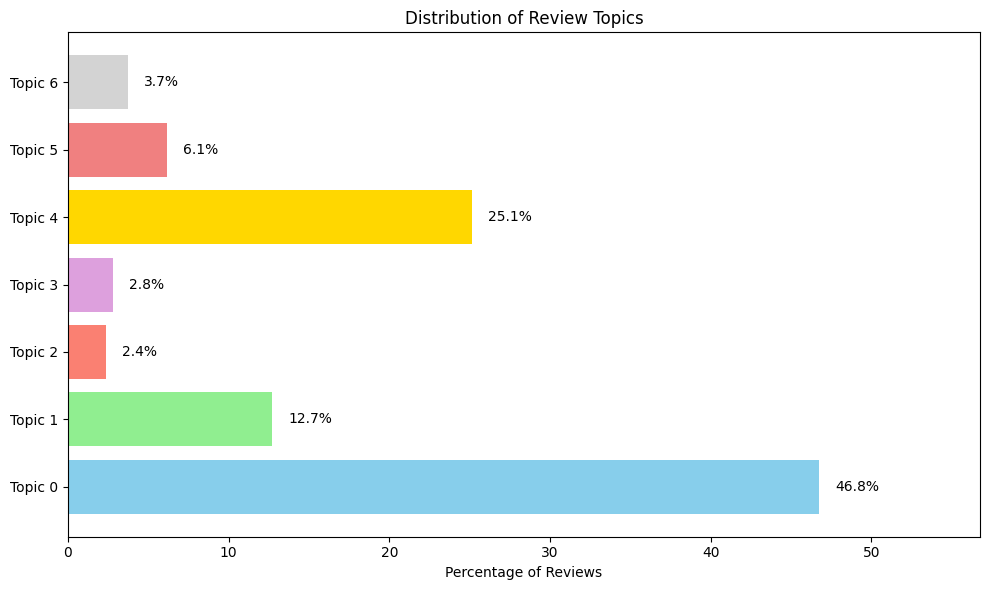

In [47]:
# # Assign each review to its most probable topic using the best LDA model
# topic_assignments = [max(best_tuned_lda.get_document_topics(bow), key=lambda x: x[1])[0] for bow in lda_corpus_bow]

# # Count the number of reviews per topic
# topic_counts = pd.Series(topic_assignments).value_counts().sort_index()

# # Calculate the proportion (%) of each topic
# topic_proportions = topic_counts / topic_counts.sum() * 100

topic_distributions = [dict(best_tuned_lda.get_document_topics(bow)) for bow in lda_corpus_bow]
topic_matrix = np.zeros((len(topic_distributions), 7))

for i, doc in enumerate(topic_distributions):
    for topic_id, prob in doc.items():
        topic_matrix[i, topic_id] = prob

topic_proportions = topic_matrix.mean(axis=0) * 100

# Define topic names based on interpretation above
topic_names = {
    0: "Topic 0",
    1: "Topic 1",
    2: "Topic 2",
    3: "Topic 3",
    4: "Topic 4",
    5: "Topic 5",
    6: "Topic 6",
}

# Visualize distribution of topics
plt.figure(figsize=(10, 6))
bars = plt.barh(
    [topic_names[i] for i in range(len(topic_proportions))],
    topic_proportions,
    color=['skyblue', 'lightgreen', 'salmon', 'plum', 'gold', 'lightcoral', 'lightgray']
)

for bar, value in zip(bars, topic_proportions):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f"{value:.1f}%", va='center', fontsize=10)

plt.xlabel('Percentage of Reviews')
plt.title('Distribution of Review Topics')
plt.xlim(0, max(topic_proportions) + 10)
plt.tight_layout()
plt.show()
